In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

from datetime import datetime

from fancyimpute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [2]:
## Global Variables
dataset_publish_date = 'May-2019'
test_data_size = 0.15
number_of_splits = 3

# Custom Methods

In [3]:
def get_missing_value_count(data,feature):
    return (data[data[feature].isna() == True].shape[0]/data[feature].shape[0])*100

In [4]:
def encode_categorical_variable(data, feature):
    oe = OrdinalEncoder()
    data[feature] = oe.fit_transform(np.array(data[feature].astype(str)).reshape(-1, 1))
    return data[feature]

In [5]:
def impute_by_constant(data, feature, const_value):
    return data[feature].fillna(const_value)

In [6]:
def impute_by_mice(data, feature, data_type):
    if data_type == 'float':
        return IterativeImputer().fit_transform(np.array(data[feature].astype(float)).reshape(-1, 1))
    elif data_type == 'str':
        return IterativeImputer().fit_transform(np.array(data[feature].astype(str)).reshape(-1, 1))

In [7]:
def impute_by_knn(data, neighbors):
    features = data.columns
    temp_df = KNNImputer(n_neighbors=neighbors).fit_transform(data) #imputation returns nd-array
    return pd.DataFrame(temp_df, columns=features) #convert nd-array to series

In [8]:
def scale_variable(dataset, target_var):
    #separate the target variable
    dataset = loan_data.copy()
    target = dataset[target_var]
    dataset.drop([target_var], axis=1, inplace=True)
    #scaling of features
    scaler = StandardScaler()
    scaler.fit(dataset)
    dataset = pd.DataFrame(scaler.transform(dataset), columns=dataset.columns)
    #add target back to dataset
    dataset[target_var] = target.reset_index().drop(['index'], axis=1)[target_var]
    return dataset

In [9]:
def variable_scale_analysis(dataset, features, graph_name):
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.set_title(graph_name)
    for feature in features:
        print(feature, ' : ', dataset[feature].dtype)
        sns.kdeplot(dataset[feature], ax=ax1, cumulative=True, bw=1.5)
    plt.show()

In [10]:
# Binning of dependent variable into categories: Good, Bad and Current loan
def loan_type(status):
    bad_loan = ['Charged Off', 'Default', 'Late (31-120 days)']
    current_loan = ['Current', 'In Grace Period', 'Late (16-30 days)']
    if status in bad_loan:
        return 0
        #return 'Bad Loan'
    elif status in current_loan:
        return 2
        #return 'Current Loan'
    else:
        return 1
        #return 'Good Loan'

In [11]:
def count_number_of_months(given_date):
    end_date = datetime.strptime(dataset_publish_date, '%b-%Y')
    start_date = datetime.strptime(given_date, '%b-%Y')
    return (end_date.year - start_date.year)*12 + (end_date.month - start_date.month)

In [12]:
def get_heat_map(data, features, x_size, y_size, title):
    f, ax = plt.subplots(figsize=(x_size, y_size))
    corr = data[features].corr()
    ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
                     cmap=sns.diverging_palette(240,10,as_cmap=True), 
                     annot=True, vmin=-1, vmax=1)
    ax.set_title(title)

# Read dataset

In [13]:
loan_data = pd.read_csv('datasets/LendingClub/AcceptedLoans_2007_to_2018.csv', low_memory=False)
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocessing the data

In [14]:
indices_to_be_dropped = loan_data[loan_data['id'].str.contains('Total amount funded in policy code')].index
loan_data.drop(index=indices_to_be_dropped, axis=0, inplace=True)

indices_to_be_dropped = loan_data[loan_data['id'].str.contains('Loans that do not meet the credit policy')].index
loan_data.drop(index=indices_to_be_dropped, axis=0, inplace=True)

In [15]:
loan_data['loan_status'] = loan_data['loan_status'].replace(to_replace='Does not meet the credit policy. Status:Fully Paid', 
                                                  value='Fully Paid')
loan_data['loan_status'] = loan_data['loan_status'].replace(to_replace='Does not meet the credit policy. Status:Charged Off', 
                                                  value='Charged Off')

In [16]:
loan_data_final_predict = loan_data[loan_data['loan_status'].isin(['Issued', 
                                                                   'Current', 
                                                                   'In Grace Period', 
                                                                   'Late (16-30 days)'])]

In [17]:
indexes = loan_data[loan_data['loan_status'].isin(['Issued', 
                                                   'Current', 
                                                   'In Grace Period', 
                                                   'Late (16-30 days)'])].index
loan_data.drop(indexes , inplace=True)

In [18]:
loan_data['loan_type'] = loan_data['loan_status'].apply(loan_type)

In [19]:
loan_data['issue_d'] = (pd.to_datetime(loan_data['issue_d']).dt.year).astype(int)

In [20]:
loan_data['emp_length'].fillna(value=0,inplace=True)
loan_data['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
loan_data['emp_length'] = loan_data['emp_length'].astype(int)
loan_data['emp_length'].replace(to_replace=0, value=np.nan, inplace=True)

**Handling variables specific to currently active loans**

In [21]:
loan_data['last_credit_pull_d'] = impute_by_constant(loan_data, 'last_credit_pull_d', 'May-2019').apply(count_number_of_months)
loan_data['last_pymnt_d'] = impute_by_constant(loan_data, 'last_pymnt_d', 'May-2019').apply(count_number_of_months)

In [22]:
print('Now, the dataset has ', loan_data.shape[0], ' records and ', loan_data.shape[1], ' variables.')

Now, the dataset has  1369566  records and  152  variables.


**Create sample from dataset (for dev purpose only)**

In [23]:

loan_data = loan_data.sample(n=round(0.1*loan_data.shape[0]))
print('The sampled dataset has ',loan_data.shape[0],' records and ',loan_data.shape[1],' variables.')


The sampled dataset has  136957  records and  152  variables.


# Feature Engineering

**Dropping features having redundant data, too many missing values and high correlation with other features**

In [24]:
cols_to_be_dropped = ['loan_status','acc_now_delinq','all_util','application_type','desc','earliest_cr_line','emp_title','fico_range_low',
                      'funded_amnt_inv','grade','id','il_util','inq_fi','installment','title','loan_amnt','max_bal_bc','member_id','num_tl_120dpd_2m',
                      'num_tl_op_past_12m','open_acc_6m','open_il_24m','open_rv_24m','out_prncp','out_prncp_inv','pymnt_plan','tot_cur_bal','total_bal_il',
                      'total_pymnt','total_pymnt_inv','url','zip_code','sec_app_earliest_cr_line','hardship_type','deferral_term',
                      'hardship_length','disbursement_method','last_pymnt_amnt','mths_since_last_major_derog','mths_since_last_record','mths_since_rcnt_il',
                      'mths_since_recent_bc_dlq','mths_since_recent_revol_delinq','next_pymnt_d', 'open_il_12m','open_act_il','open_rv_12m','total_cu_tl',
                      'revol_bal_joint','policy_code','recoveries','collection_recovery_fee','num_rev_tl_bal_gt_0','int_rate','sec_app_fico_range_low',
                      'sec_app_fico_range_high','sec_app_inq_last_6mths','sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il',
                      'sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog',
                      'hardship_reason','hardship_status','hardship_amount','hardship_start_date','hardship_end_date','payment_plan_start_date',
                      'hardship_dpd','hardship_loan_status','orig_projected_additional_accrued_interest','hardship_payoff_balance_amount',
                      'hardship_last_payment_amount','debt_settlement_flag','debt_settlement_flag_date','settlement_status','settlement_date',
                      'settlement_amount','settlement_percentage','settlement_term','last_fico_range_low']

In [25]:
loan_data.drop(cols_to_be_dropped, axis=1, inplace=True)

In [26]:
print('Now, the dataset has ', loan_data.shape[0], ' records and ', loan_data.shape[1], ' variables.')

Now, the dataset has  136957  records and  68  variables.


**Handling Missing Values (using zero imputation)**

In [27]:
cols_for_zero_imputation = ['acc_open_past_24mths','annual_inc_joint','chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs','dti_joint',
                            'num_tl_30dpd','num_tl_90g_dpd_24m','open_acc','total_bc_limit','total_il_high_credit_limit', 'delinq_amnt', 'total_acc',
                            'mo_sin_old_il_acct','num_il_tl','tot_coll_amt','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mths_since_last_delinq',
                            'mths_since_recent_bc','mths_since_recent_inq','mort_acc','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats',
                            'num_bc_tl','num_op_rev_tl','num_rev_accts','num_sats','pct_tl_nvr_dlq','percent_bc_gt_75','revol_util']

In [28]:
for feature in cols_for_zero_imputation:
    loan_data[feature] = impute_by_constant(loan_data, feature, 0)

**Handling Missing Values (using median imputation)**

In [29]:
cols_for_median_imputation = ['annual_inc','dti','total_rev_hi_lim','avg_cur_bal','tot_hi_cred_lim','bc_open_to_buy','bc_util','total_bal_ex_mort']

In [30]:
for feature in cols_for_median_imputation:
    loan_data[feature] = impute_by_constant(loan_data, feature, loan_data[feature].median())

**Handling Missing Values (using mode imputation)**

In [31]:
cols_for_mode_imputation = []

**Encoding categorical features**

In [32]:
cols_for_encoding = ['term','sub_grade','home_ownership','verification_status','purpose','addr_state','initial_list_status','hardship_flag']

In [33]:
for feature in loan_data.columns:
    if loan_data[feature].dtype == 'object':
        loan_data[feature] = encode_categorical_variable(loan_data, feature)

**Handling Missing Values (using knn imputation)**

In [34]:
cols_for_knn_imputation = ['emp_length', 'inq_last_12m', 'inq_last_6mths', 'pub_rec_bankruptcies','tax_liens','pub_rec']

In [35]:
#X = impute_by_knn(X, 4)

In [36]:
## knn imputation throwing error. hence applied mode imputation
for feature in cols_for_knn_imputation:
    loan_data[feature] = impute_by_constant(loan_data, feature, loan_data[feature].mode().get(0))

**Handling Missing Values (using 'missing' indicator imputation in categorical variables)**

In [37]:
loan_data['verification_status_joint'] = impute_by_constant(loan_data, 'verification_status_joint', 'Not Applicable')

**Feature Scaling**

In [38]:
loan_data_scaled = scale_variable(loan_data, 'loan_type')

# Pre-Model Data Processing

**Dropping columns as per feature selection results from previous tests**

In [39]:
'''
cols_dropped_post_feature_selection = []
loan_data.drop(cols_dropped_post_feature_selection, axis=1, inplace=True)
'''

'\ncols_dropped_post_feature_selection = []\nloan_data.drop(cols_dropped_post_feature_selection, axis=1, inplace=True)\n'

**Get the feature and target variables**

In [40]:
y = loan_data['loan_type']
X = loan_data.drop(['loan_type'], axis=1)

In [41]:
y_scaled = loan_data_scaled['loan_type']
X_scaled = loan_data_scaled.drop(['loan_type'], axis=1)

In [42]:
print('Now, the dataset has ', X.shape[0], ' records and ', X.shape[1], ' variables.')

Now, the dataset has  136957  records and  67  variables.


**Oversampling**

In [43]:
features = X.columns

sm = RandomOverSampler()
X, y = sm.fit_sample(X, y)

X = pd.DataFrame(data=X, columns=features)
y = pd.Series(data=y)

print('Now, the dataset has ', X.shape[0], ' records and ', X.shape[1], ' variables.')

Now, the dataset has  216014  records and  67  variables.


**Defining the value of k for cross validation**

In [44]:
skf = StratifiedKFold(n_splits=number_of_splits)
n_split = skf.get_n_splits(X)

# Data Modelling - Logistic Regression

In [45]:
'''
clf = LogisticRegression(random_state=0)
parameters = {
    'solver': ['sag'],
    'C':  [1, 10, 100],
    'penalty':  ['l2'],
    'multi_class': ['ovr'],
    'max_iter' : [1000]
     }

grid = GridSearchCV(clf, parameters, n_jobs=4, scoring='precision_weighted', cv=n_split, verbose=20)
grid.fit(X_scaled, y_scaled)
print('Best Estimator: ', grid.best_estimator_)
print('Best Score: ', grid.best_score_)
'''

'''
# 0.9125633304946389
'solver': ['sag'],
'C':  [1],
'penalty':  ['l2'],
'multi_class': ['ovr']
'''

"\n# 0.9125633304946389\n'solver': ['sag'],\n'C':  [1],\n'penalty':  ['l2'],\n'multi_class': ['ovr']\n"

In [46]:
'''
for train_index, test_index in skf.split(X, y):
    print('*******************Start of split*******************')
    ## split into train and test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ## model fitting using train data
    lg_clf = LogisticRegression(solver='sag', C=1 , penalty='l2', multi_class='auto', 
                            max_iter=10000, n_jobs=-1, random_state=0)
    lg_clf.fit(X_train, y_train)
    ## predicting using test data
    y_pred = lg_clf.predict(X_test)
    ## assessing model performance
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    #roc_auc = roc_auc_score(y_test, y_pred)
    print('Accuracy : ', acc)
    print('Precision : ', prec)
    print('Recall : ', rec)
    print('F1 : ', f1)
    #print('ROC-AUC Score: ', roc_auc)
'''

"\nfor train_index, test_index in skf.split(X, y):\n    print('*******************Start of split*******************')\n    ## split into train and test data\n    X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n    y_train, y_test = y.iloc[train_index], y.iloc[test_index]\n    ## model fitting using train data\n    lg_clf = LogisticRegression(solver='sag', C=1 , penalty='l2', multi_class='auto', \n                            max_iter=10000, n_jobs=-1, random_state=0)\n    lg_clf.fit(X_train, y_train)\n    ## predicting using test data\n    y_pred = lg_clf.predict(X_test)\n    ## assessing model performance\n    acc = accuracy_score(y_test, y_pred)\n    prec = precision_score(y_test, y_pred)\n    rec = recall_score(y_test, y_pred)\n    f1 = f1_score(y_test, y_pred)\n    #roc_auc = roc_auc_score(y_test, y_pred)\n    print('Accuracy : ', acc)\n    print('Precision : ', prec)\n    print('Recall : ', rec)\n    print('F1 : ', f1)\n    #print('ROC-AUC Score: ', roc_auc)\n"

In [47]:
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled,test_size=test_data_size,random_state=0)
## model fitting using train data
lg_clf = LogisticRegression(solver='sag', C=1 , penalty='l2', multi_class='auto', 
                            max_iter=10000, n_jobs=-1, random_state=0, verbose=20)
lg_clf.fit(X_train, y_train)
## predicting using test data
y_pred = lg_clf.predict(X_test)
## assessing model performance
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
#roc_auc = roc_auc_score(y_test, y_pred)
print('Accuracy : ', acc)
print('Precision : ', prec)
print('Recall : ', rec)
print('F1 : ', f1)
#print('ROC-AUC Score: ', roc_auc)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 2277 epochs took 189 seconds
Accuracy :  0.99586253894081
Precision :  0.9951492079086331
Recall :  0.9996299266021094
F1 :  0.9973845349087664


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.1min finished


Text(0.5, 1.0, 'Confusion Matrix')

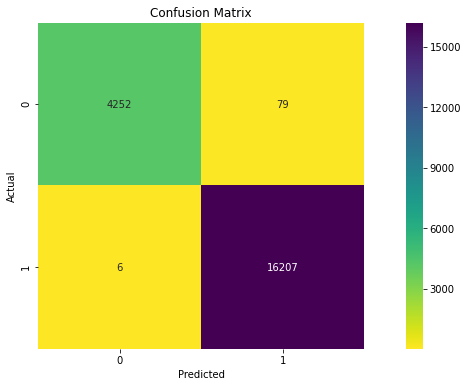

In [48]:
## confusion matrix
plt.figure(figsize=(15,6))
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
#plt.savefig('pics/confusion_matrix.png')

In [49]:
print(classification_report(y_test, y_pred, target_names=['Bad Loans', 'Good Loans']))

              precision    recall  f1-score   support

   Bad Loans       1.00      0.98      0.99      4331
  Good Loans       1.00      1.00      1.00     16213

    accuracy                           1.00     20544
   macro avg       1.00      0.99      0.99     20544
weighted avg       1.00      1.00      1.00     20544



AUC Score:  0.999673618789623


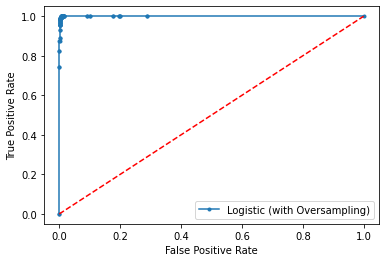

In [50]:
y_proba = lg_clf.predict_proba(X_test)[:, 1]
print('AUC Score: ', roc_auc_score(y_test, y_proba))

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, marker='.', label='Logistic (with Oversampling)')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
#plt.savefig('pics/auc_curve.png')

**Find the best features of the dataset**

In [51]:
importance = pd.Series(lg_clf.coef_[0], index=list(X_train.columns))

feature_imp_df = pd.DataFrame({'Feature_Name': list(X_train.columns),
                               'Feature_Importance': importance})
feature_imp_df.sort_values(by=['Feature_Importance'], ascending=True, inplace=True)

                                          Feature_Name  Feature_Importance
total_rev_hi_lim                      total_rev_hi_lim            0.004989
num_bc_sats                                num_bc_sats            0.016533
collections_12_mths_ex_med  collections_12_mths_ex_med            0.017475
mths_since_recent_inq            mths_since_recent_inq            0.017476
delinq_2yrs                                delinq_2yrs            0.019828
pub_rec_bankruptcies              pub_rec_bankruptcies            0.023646
tax_liens                                    tax_liens            0.024861
annual_inc                                  annual_inc            0.031225
num_accts_ever_120_pd            num_accts_ever_120_pd            0.031746
mort_acc                                      mort_acc            0.037869
num_sats                                      num_sats            0.042257
delinq_amnt                                delinq_amnt            0.049473
num_op_rev_tl            

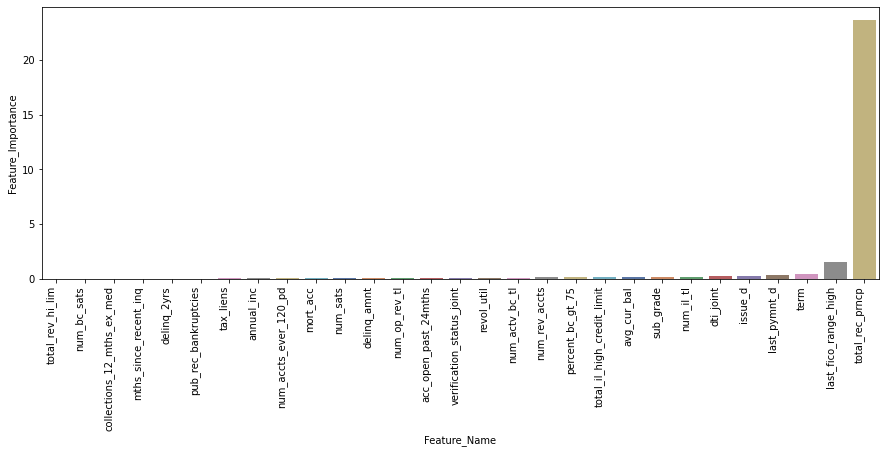

In [52]:
feature_imp_df_positive = feature_imp_df[feature_imp_df['Feature_Importance'] >= 0]
print(feature_imp_df_positive)

plt.figure(figsize=(15,5))
ax = sns.barplot(x='Feature_Name', y='Feature_Importance', data=feature_imp_df_positive, palette='deep')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.savefig('pics/logistic_reg_oversampling_feature_importance_poistive.png')

                                      Feature_Name  Feature_Importance
funded_amnt                            funded_amnt          -21.055114
total_rec_int                        total_rec_int           -1.029655
total_acc                                total_acc           -0.264792
bc_open_to_buy                      bc_open_to_buy           -0.221731
bc_util                                    bc_util           -0.194430
total_rec_late_fee              total_rec_late_fee           -0.187785
hardship_flag                        hardship_flag           -0.121814
mo_sin_old_rev_tl_op          mo_sin_old_rev_tl_op           -0.080887
num_actv_rev_tl                    num_actv_rev_tl           -0.080349
annual_inc_joint                  annual_inc_joint           -0.074166
tot_hi_cred_lim                    tot_hi_cred_lim           -0.070738
open_acc                                  open_acc           -0.070619
total_bal_ex_mort                total_bal_ex_mort           -0.063056
dti   

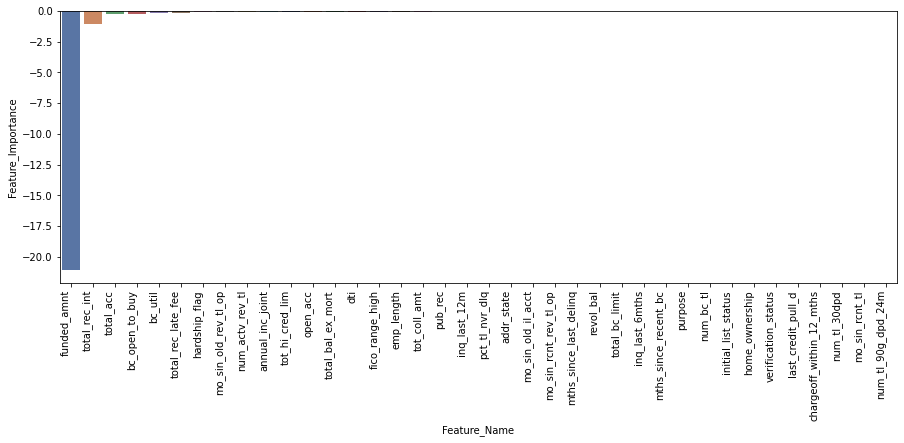

In [53]:
feature_imp_df_negative = feature_imp_df[feature_imp_df['Feature_Importance'] < 0]
print(feature_imp_df_negative)

plt.figure(figsize=(15,5))
ax = sns.barplot(x='Feature_Name', y='Feature_Importance', data=feature_imp_df_negative, palette='deep')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.savefig('pics/logistic_reg_oversampling_feature_importance_negative.png')

In [58]:
import lime
import lime.lime_tabular

def prob(data):
    return np.array(list(zip(1-lg_clf.predict(data),lg_clf.predict(data))))
    
explainer = lime.lime_tabular.LimeTabularExplainer(X_train[list(X_train.columns)].astype(int).values,  
                                                   mode='classification', training_labels=y_train, 
                                                   feature_names=list(X_train.columns))

# asking for explanation for LIME model
i = 1
exp = explainer.explain_instance(X_train.loc[i, list(X_train.columns)].astype(int).values, prob, num_features=5)

exp.show_in_notebook(show_table=True)

# Data Modelling - Decision Tree

**Hyper parameter tuning**

In [54]:
'''
clf = DecisionTreeClassifier(random_state=0)
parameters = {
    'criterion': ['gini'],
    'max_depth':  [7],
    'min_samples_split':  [2],
    'min_samples_leaf': [1],
    'max_leaf_nodes' : [20],
    'max_features' : ['auto']
     }

grid = GridSearchCV(clf, parameters, n_jobs=4, scoring='precision_weighted', cv=2, verbose=20)
grid.fit(X, y)
print('Best Estimator: ', grid.best_estimator_)
print('Best Score: ', grid.best_score_)
'''

"\nclf = DecisionTreeClassifier(random_state=0)\nparameters = {\n    'criterion': ['gini'],\n    'max_depth':  [7],\n    'min_samples_split':  [2],\n    'min_samples_leaf': [1],\n    'max_leaf_nodes' : [20],\n    'max_features' : ['auto']\n     }\n\ngrid = GridSearchCV(clf, parameters, n_jobs=4, scoring='precision_weighted', cv=2, verbose=20)\ngrid.fit(X, y)\nprint('Best Estimator: ', grid.best_estimator_)\nprint('Best Score: ', grid.best_score_)\n"

**Modelling: Train, Test and Model Assessment**

In [55]:
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_data_size,random_state=0)
## model fitting using train data
dt_clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, min_samples_split=2, 
                                max_depth=9, max_features='auto', max_leaf_nodes=20, random_state=0)
dt_clf.fit(X_train, y_train)
## predicting using test data
y_pred = dt_clf.predict(X_test)
## assessing model performance
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
#roc_auc = roc_auc_score(y_test, y_pred)
print('Accuracy : ', acc)
print('Precision : ', prec)
print('Recall : ', rec)
print('F1 : ', f1)
#print('ROC-AUC Score: ', roc_auc)

Accuracy :  0.8912080765538385
Precision :  0.8934375387669024
Recall :  0.8891906907833816
F1 :  0.8913090560316822


Text(0.5, 1.0, 'Confusion Matrix')

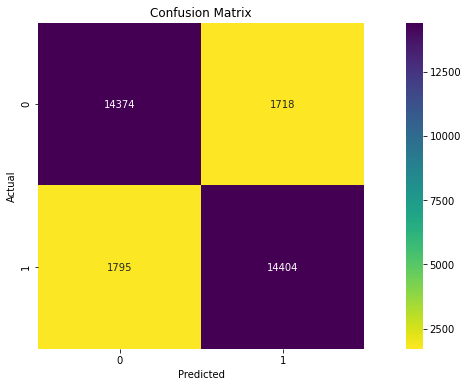

In [56]:
## confusion matrix
plt.figure(figsize=(15,6))
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
#plt.savefig('pics/confusion_matrix.png')

In [57]:
print(classification_report(y_test, y_pred, target_names=['Bad Loans', 'Good Loans']))

              precision    recall  f1-score   support

   Bad Loans       0.89      0.89      0.89     16092
  Good Loans       0.89      0.89      0.89     16199

    accuracy                           0.89     32291
   macro avg       0.89      0.89      0.89     32291
weighted avg       0.89      0.89      0.89     32291



AUC Score:  0.9366649109892333


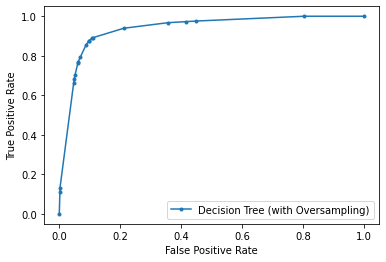

In [58]:
y_proba = dt_clf.predict_proba(X_test)[:, 1]
print('AUC Score: ', roc_auc_score(y_test, y_proba))

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, marker='.', label='Decision Tree (with Oversampling)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
#plt.savefig('pics/auc_curve.png')

**Find the best features of the dataset**

In [59]:
importance = pd.Series(dt_clf.feature_importances_, index=list(X_train.columns))

feature_imp_df = pd.DataFrame({'Feature_Name': list(X_train.columns),
                               'Feature_Importance': importance})
feature_imp_df.sort_values(by=['Feature_Importance'], ascending=True, inplace=True)

                                      Feature_Name  Feature_Importance
inq_last_12m                          inq_last_12m            0.000000
acc_open_past_24mths          acc_open_past_24mths            0.000000
avg_cur_bal                            avg_cur_bal            0.000000
bc_open_to_buy                      bc_open_to_buy            0.000000
chargeoff_within_12_mths  chargeoff_within_12_mths            0.000000
...                                            ...                 ...
term                                          term            0.019925
last_credit_pull_d              last_credit_pull_d            0.043651
funded_amnt                            funded_amnt            0.046371
total_rec_prncp                    total_rec_prncp            0.063265
last_fico_range_high          last_fico_range_high            0.801347

[67 rows x 2 columns]


[Text(0, 0, 'inq_last_12m'),
 Text(0, 0, 'acc_open_past_24mths'),
 Text(0, 0, 'avg_cur_bal'),
 Text(0, 0, 'bc_open_to_buy'),
 Text(0, 0, 'chargeoff_within_12_mths'),
 Text(0, 0, 'delinq_amnt'),
 Text(0, 0, 'mo_sin_old_il_acct'),
 Text(0, 0, 'mo_sin_old_rev_tl_op'),
 Text(0, 0, 'mo_sin_rcnt_rev_tl_op'),
 Text(0, 0, 'mo_sin_rcnt_tl'),
 Text(0, 0, 'mort_acc'),
 Text(0, 0, 'mths_since_recent_bc'),
 Text(0, 0, 'mths_since_recent_inq'),
 Text(0, 0, 'num_accts_ever_120_pd'),
 Text(0, 0, 'total_il_high_credit_limit'),
 Text(0, 0, 'num_actv_bc_tl'),
 Text(0, 0, 'num_bc_sats'),
 Text(0, 0, 'num_bc_tl'),
 Text(0, 0, 'num_il_tl'),
 Text(0, 0, 'num_op_rev_tl'),
 Text(0, 0, 'num_rev_accts'),
 Text(0, 0, 'num_tl_30dpd'),
 Text(0, 0, 'num_tl_90g_dpd_24m'),
 Text(0, 0, 'percent_bc_gt_75'),
 Text(0, 0, 'pub_rec_bankruptcies'),
 Text(0, 0, 'tax_liens'),
 Text(0, 0, 'tot_hi_cred_lim'),
 Text(0, 0, 'total_bal_ex_mort'),
 Text(0, 0, 'total_bc_limit'),
 Text(0, 0, 'num_actv_rev_tl'),
 Text(0, 0, 'total_rev_h

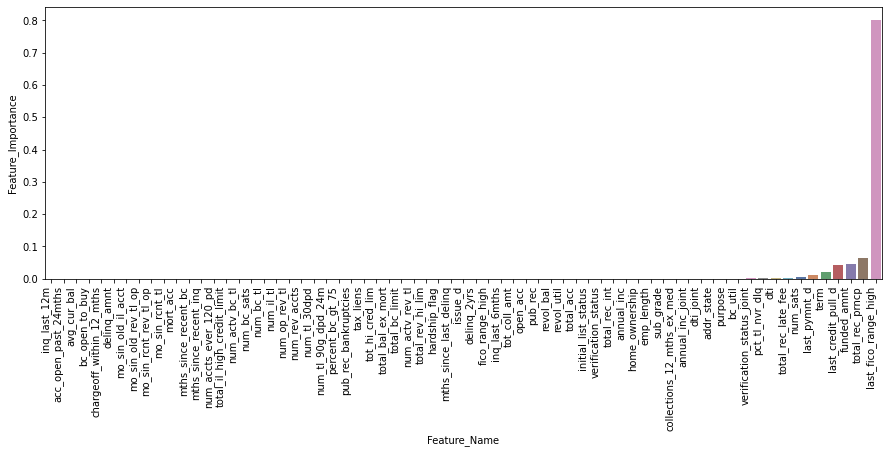

In [60]:
print(feature_imp_df)

plt.figure(figsize=(15,5))
ax = sns.barplot(x='Feature_Name', y='Feature_Importance', data=feature_imp_df, palette='deep')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
#plt.savefig('pics/logistic_reg_oversampling_feature_importance_poistive.png')

# Data Modelling - RandomForest

**Hyper parameter tuning**

In [61]:
'''
clf = RandomForestClassifier(random_state=0)
parameters = {
    'criterion': ['entropy'],
    'max_depth':  [9],
    'min_samples_split':  [2],
    'min_samples_leaf': [1],
    'max_leaf_nodes' : [21],
    'max_features' : ['auto'],
    'n_estimators' : [400]
     }

grid = GridSearchCV(clf, parameters, n_jobs=4, scoring='accuracy', cv=2, verbose=20)
grid.fit(X, y)
print('Best Estimator: ', grid.best_estimator_)
print('Best Score: ', grid.best_score_)
'''

"\nclf = RandomForestClassifier(random_state=0)\nparameters = {\n    'criterion': ['entropy'],\n    'max_depth':  [9],\n    'min_samples_split':  [2],\n    'min_samples_leaf': [1],\n    'max_leaf_nodes' : [21],\n    'max_features' : ['auto'],\n    'n_estimators' : [400]\n     }\n\ngrid = GridSearchCV(clf, parameters, n_jobs=4, scoring='accuracy', cv=2, verbose=20)\ngrid.fit(X, y)\nprint('Best Estimator: ', grid.best_estimator_)\nprint('Best Score: ', grid.best_score_)\n"

**Modelling: Train, Test and Model Assessment**

In [62]:
'''
for train_index, test_index in skf.split(X, y):
    print('*******************Start of split*******************')
    ## split into train and test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ## model fitting using train data
    dt_clf = DecisionTreeClassifier(criterion='gini', min_samples_leaf=1, min_samples_split=2,  
                                    max_depth=7, max_features='auto', max_leaf_nodes=20, random_state=0)
    dt_clf.fit(X_train, y_train)
    ## predicting using test data
    y_pred = dt_clf.predict(X_test)
    ## assessing model performance
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    #roc_auc = roc_auc_score(y_test, y_pred)
    print('Accuracy : ', acc)
    print('Precision : ', prec)
    print('Recall : ', rec)
    print('F1 : ', f1)
    #print('ROC-AUC Score: ', roc_auc)
'''

"\nfor train_index, test_index in skf.split(X, y):\n    print('*******************Start of split*******************')\n    ## split into train and test data\n    X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n    y_train, y_test = y.iloc[train_index], y.iloc[test_index]\n    ## model fitting using train data\n    dt_clf = DecisionTreeClassifier(criterion='gini', min_samples_leaf=1, min_samples_split=2,  \n                                    max_depth=7, max_features='auto', max_leaf_nodes=20, random_state=0)\n    dt_clf.fit(X_train, y_train)\n    ## predicting using test data\n    y_pred = dt_clf.predict(X_test)\n    ## assessing model performance\n    acc = accuracy_score(y_test, y_pred)\n    prec = precision_score(y_test, y_pred)\n    rec = recall_score(y_test, y_pred)\n    f1 = f1_score(y_test, y_pred)\n    #roc_auc = roc_auc_score(y_test, y_pred)\n    print('Accuracy : ', acc)\n    print('Precision : ', prec)\n    print('Recall : ', rec)\n    print('F1 : ', f1)\n    #pr

In [63]:
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_data_size,random_state=0)
## model fitting using train data
rf_clf = RandomForestClassifier(criterion='entropy', min_samples_leaf=1, min_samples_split=2, 
                                max_depth=9, max_features='auto', max_leaf_nodes=21, 
                                n_estimators=400, random_state=0)
rf_clf.fit(X_train, y_train)
## predicting using test data
y_pred = rf_clf.predict(X_test)
## assessing model performance
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
#roc_auc = roc_auc_score(y_test, y_pred)
print('Accuracy : ', acc)
print('Precision : ', prec)
print('Recall : ', rec)
print('F1 : ', f1)
#print('ROC-AUC Score: ', roc_auc)

Accuracy :  0.9296088693443993
Precision :  0.9475510991129965
Recall :  0.9100561763071795
F1 :  0.9284252290833518


Text(0.5, 1.0, 'Confusion Matrix')

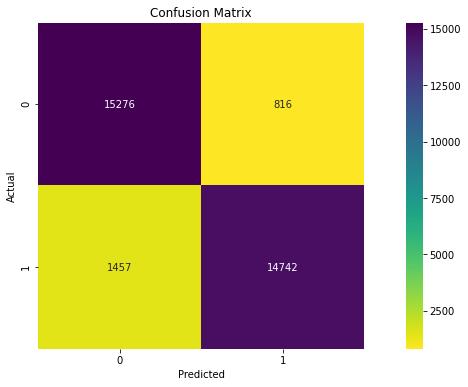

In [64]:
## confusion matrix
plt.figure(figsize=(15,6))
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
#plt.savefig('pics/confusion_matrix.png')

In [65]:
print(classification_report(y_test, y_pred, target_names=['Bad Loans', 'Good Loans']))

              precision    recall  f1-score   support

   Bad Loans       0.91      0.95      0.93     16092
  Good Loans       0.95      0.91      0.93     16199

    accuracy                           0.93     32291
   macro avg       0.93      0.93      0.93     32291
weighted avg       0.93      0.93      0.93     32291



AUC Score:  0.9835926715109953


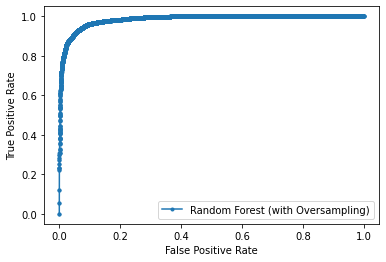

In [66]:
y_proba = rf_clf.predict_proba(X_test)[:, 1]
print('AUC Score: ', roc_auc_score(y_test, y_proba))

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, marker='.', label='Random Forest (with Oversampling)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
#plt.savefig('pics/auc_curve.png')

**Find the best features of the dataset**

In [67]:
importance = pd.Series(rf_clf.feature_importances_, index=list(X_train.columns))

feature_imp_df = pd.DataFrame({'Feature_Name': list(X_train.columns),
                               'Feature_Importance': importance})
feature_imp_df.sort_values(by=['Feature_Importance'], ascending=True, inplace=True)

                                  Feature_Name  Feature_Importance
num_tl_90g_dpd_24m          num_tl_90g_dpd_24m            0.000000
mths_since_last_delinq  mths_since_last_delinq            0.000000
pub_rec_bankruptcies      pub_rec_bankruptcies            0.000000
delinq_2yrs                        delinq_2yrs            0.000000
tax_liens                            tax_liens            0.000000
...                                        ...                 ...
last_credit_pull_d          last_credit_pull_d            0.032356
sub_grade                            sub_grade            0.042628
funded_amnt                        funded_amnt            0.046109
total_rec_prncp                total_rec_prncp            0.299909
last_fico_range_high      last_fico_range_high            0.446798

[67 rows x 2 columns]


[Text(0, 0, 'num_tl_90g_dpd_24m'),
 Text(0, 0, 'mths_since_last_delinq'),
 Text(0, 0, 'pub_rec_bankruptcies'),
 Text(0, 0, 'delinq_2yrs'),
 Text(0, 0, 'tax_liens'),
 Text(0, 0, 'addr_state'),
 Text(0, 0, 'pub_rec'),
 Text(0, 0, 'num_tl_30dpd'),
 Text(0, 0, 'delinq_amnt'),
 Text(0, 0, 'collections_12_mths_ex_med'),
 Text(0, 0, 'chargeoff_within_12_mths'),
 Text(0, 0, 'num_accts_ever_120_pd'),
 Text(0, 0, 'mths_since_recent_inq'),
 Text(0, 0, 'tot_coll_amt'),
 Text(0, 0, 'emp_length'),
 Text(0, 0, 'total_acc'),
 Text(0, 0, 'total_il_high_credit_limit'),
 Text(0, 0, 'open_acc'),
 Text(0, 0, 'mo_sin_rcnt_tl'),
 Text(0, 0, 'num_il_tl'),
 Text(0, 0, 'mo_sin_old_il_acct'),
 Text(0, 0, 'hardship_flag'),
 Text(0, 0, 'pct_tl_nvr_dlq'),
 Text(0, 0, 'inq_last_6mths'),
 Text(0, 0, 'initial_list_status'),
 Text(0, 0, 'num_bc_sats'),
 Text(0, 0, 'total_bal_ex_mort'),
 Text(0, 0, 'num_bc_tl'),
 Text(0, 0, 'mo_sin_old_rev_tl_op'),
 Text(0, 0, 'mo_sin_rcnt_rev_tl_op'),
 Text(0, 0, 'bc_util'),
 Text(0, 0

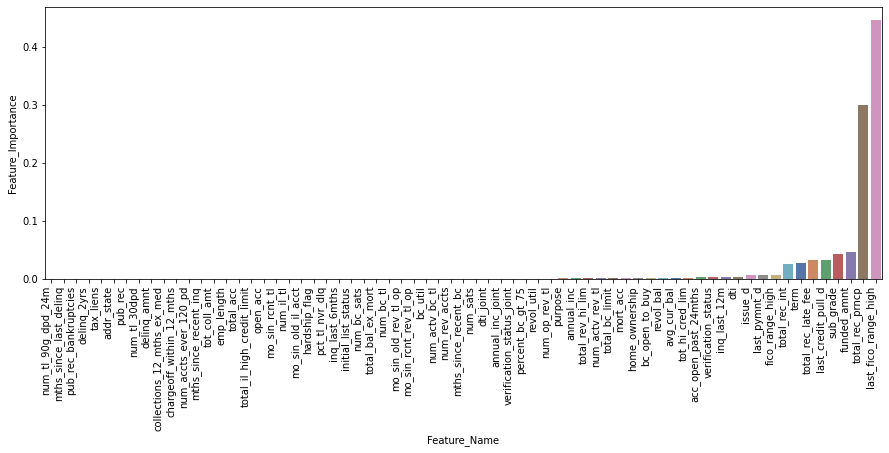

In [68]:
print(feature_imp_df)

plt.figure(figsize=(15,5))
ax = sns.barplot(x='Feature_Name', y='Feature_Importance', data=feature_imp_df, palette='deep')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
#plt.savefig('pics/logistic_reg_oversampling_feature_importance_poistive.png')

# Data Modelling - K Nearest Neighbors

**Hyper parameter tuning**

In [69]:
'''
clf = KNeighborsClassifier()
parameters = {
    'n_neighbors': list(np.arange(1,25)),
    'algorithm':  ['auto'],
    'weights':  ['uniform', 'distance'],
    'p': [1,2]
     }

grid = GridSearchCV(clf, parameters, n_jobs=4, scoring='accuracy', cv=2, verbose=20)
grid.fit(X_scaled, y_scaled)
print('Best Estimator: ', grid.best_estimator_)
print('Best Score: ', grid.best_score_)
'''

"\nclf = KNeighborsClassifier()\nparameters = {\n    'n_neighbors': list(np.arange(1,25)),\n    'algorithm':  ['auto'],\n    'weights':  ['uniform', 'distance'],\n    'p': [1,2]\n     }\n\ngrid = GridSearchCV(clf, parameters, n_jobs=4, scoring='accuracy', cv=2, verbose=20)\ngrid.fit(X_scaled, y_scaled)\nprint('Best Estimator: ', grid.best_estimator_)\nprint('Best Score: ', grid.best_score_)\n"

**Modelling: Train, Test and Model Assessment**

In [70]:
'''
for train_index, test_index in skf.split(X, y):
    print('*******************Start of split*******************')
    ## split into train and test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ## model fitting using train data
    knn_clf = KNeighborsClassifier(n_neighbors=24, algorithm='auto', weights='uniform', p=1)
    knn_clf.fit(X_train, y_train)
    ## predicting using test data
    y_pred = knn_clf.predict(X_test)
    ## assessing model performance
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    #roc_auc = roc_auc_score(y_test, y_pred)
    print('Accuracy : ', acc)
    print('Precision : ', prec)
    print('Recall : ', rec)
    print('F1 : ', f1)
    #print('ROC-AUC Score: ', roc_auc)
'''

"\nfor train_index, test_index in skf.split(X, y):\n    print('*******************Start of split*******************')\n    ## split into train and test data\n    X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n    y_train, y_test = y.iloc[train_index], y.iloc[test_index]\n    ## model fitting using train data\n    knn_clf = KNeighborsClassifier(n_neighbors=24, algorithm='auto', weights='uniform', p=1)\n    knn_clf.fit(X_train, y_train)\n    ## predicting using test data\n    y_pred = knn_clf.predict(X_test)\n    ## assessing model performance\n    acc = accuracy_score(y_test, y_pred)\n    prec = precision_score(y_test, y_pred)\n    rec = recall_score(y_test, y_pred)\n    f1 = f1_score(y_test, y_pred)\n    #roc_auc = roc_auc_score(y_test, y_pred)\n    print('Accuracy : ', acc)\n    print('Precision : ', prec)\n    print('Recall : ', rec)\n    print('F1 : ', f1)\n    #print('ROC-AUC Score: ', roc_auc)\n"

In [71]:
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled,test_size=test_data_size,random_state=0)
## model fitting using train data
knn_clf = KNeighborsClassifier(n_neighbors=22, algorithm='auto', weights='distance', p=1)
knn_clf.fit(X_train, y_train)
## predicting using test data
y_pred = knn_clf.predict(X_test)
## assessing model performance
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
#roc_auc = roc_auc_score(y_test, y_pred)
print('Accuracy : ', acc)
print('Precision : ', prec)
print('Recall : ', rec)
print('F1 : ', f1)
#print('ROC-AUC Score: ', roc_auc)

Accuracy :  0.8889213395638629
Precision :  0.878447563996697
Recall :  0.9953839436092571
F1 :  0.9332670487776348


Text(0.5, 1.0, 'Confusion Matrix')

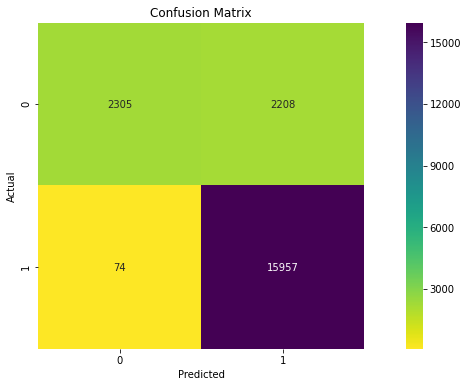

In [72]:
## confusion matrix
plt.figure(figsize=(15,6))
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
#plt.savefig('pics/confusion_matrix.png')

AUC Score:  0.9569357801566135


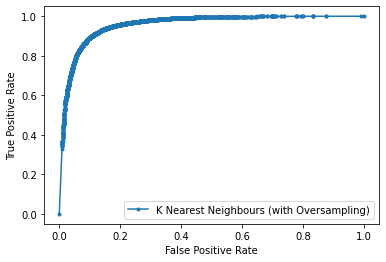

In [73]:
y_proba = knn_clf.predict_proba(X_test)[:, 1]
print('AUC Score: ', roc_auc_score(y_test, y_proba))

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, marker='.', label='K Nearest Neighbours (with Oversampling)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
#plt.savefig('pics/auc_curve.png')

# Data Modelling - Support Vector Machine

In [81]:
'''
clf = SVC(max_iter=10000,probability=True,random_state=0)
parameters = {
    'kernel': ['rbf'], 
    'gamma':  ['auto'],
    'class_weight':  ['balanced'],
    'C': [100,1000]
     }

grid = GridSearchCV(clf, parameters, n_jobs=4, scoring='accuracy', cv=2, verbose=20)
grid.fit(X_scaled, y_scaled)
print('Best Estimator: ', grid.best_estimator_)
print('Best Score: ', grid.best_score_)
'''

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.3min remaining:  2.3min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.4min finished


Best Estimator:  SVC(C=1000, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='auto',
    kernel='rbf', max_iter=10000, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)
Best Score:  0.9905663817221364


In [ ]:
'''
for train_index, test_index in skf.split(X_scaled, y_scaled):
    print('*******************Start of split*******************')
    ## split into train and test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ## model fitting using train data
    sv_clf = SVC(kernel='rbf',gamma='auto',class_weight='balanced',C=1,max_iter=10000,random_state=0)
    sv_clf.fit(X_train, y_train)
    ## predicting using test data
    y_pred = sv_clf.predict(X_test)
    ## assessing model performance
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    #roc_auc = roc_auc_score(y_test, y_pred)
    print('Accuracy : ', acc)
    print('Precision : ', prec)
    print('Recall : ', rec)
    print('F1 : ', f1)
    #print('ROC-AUC Score: ', roc_auc)
'''

In [85]:
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled,test_size=test_data_size,random_state=0)
## model fitting using train data -> for probability estimate
sv_clf_proba = SVC(kernel='rbf',gamma='auto',class_weight='balanced',
                   C=1000,max_iter=10000,probability=True,random_state=0)
sv_clf_proba.fit(X_train, y_train)
## model fitting using train data -> for prediction
sv_clf = SVC(kernel='rbf',gamma='auto',class_weight='balanced',
                   C=1000,max_iter=10000,random_state=0)
sv_clf.fit(X_train, y_train)
## predicting using test data
y_pred = sv_clf.predict(X_test)
## assessing model performance
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
#roc_auc = roc_auc_score(y_test, y_pred)
print('Accuracy : ', acc)
print('Precision : ', prec)
print('Recall : ', rec)
print('F1 : ', f1)
#print('ROC-AUC Score: ', roc_auc)

Accuracy :  0.9921631619937694
Precision :  0.9918123614873184
Recall :  0.9982650721853894
F1 :  0.9950282555661921


Text(0.5, 1.0, 'Confusion Matrix')

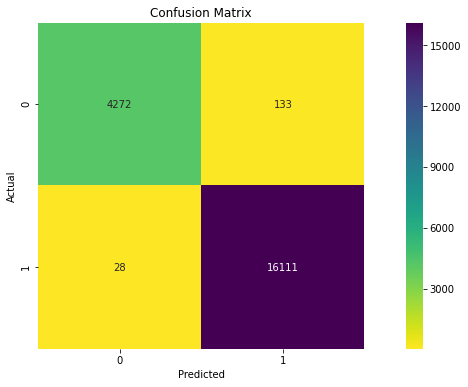

In [86]:
## confusion matrix
plt.figure(figsize=(15,6))
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
#plt.savefig('pics/confusion_matrix.png')

AUC Score:  0.9987451523403486


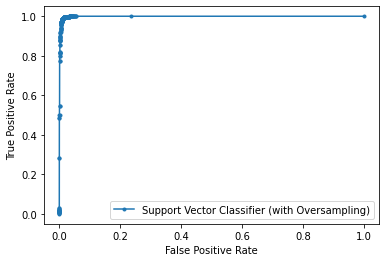

In [87]:
y_proba = sv_clf_proba.predict_proba(X_test)[:, 1]
print('AUC Score: ', roc_auc_score(y_test, y_proba))

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, marker='.', label='Support Vector Classifier (with Oversampling)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
#plt.savefig('pics/auc_curve.png')

# Model Performance Summary

<table style="width:80%">
<tr>
<th>Model Name</th>
<th>Accuracy</th>
<th>Precision</th>
<th>Recall</th>
<th>F1</th>
<th>AUC Score</th>
</tr>

<tr>
<td>Logistic Regression</td>
<td>0.9939</td>
<td>0.9925</td>
<td>0.9998</td>
<td>0.9961</td>
<td>0.9999</td>
</tr>

<tr>
<td>Support Vector Classifier</td>
<td>0.9922</td>
<td>0.9918</td>
<td>0.9983</td>
<td>0.995</td>
<td>0.9987</td>
</tr>

<tr>
<td>Random Forest</td>
<td>0.9446</td>
<td>0.9532</td>
<td>0.9356</td>
<td>0.9443</td>
<td>0.9867</td>
</tr>

<tr>
<td>K Nearest Neighbours</td>
<td>0.9032</td>
<td>0.8943</td>
<td>0.9942</td>
<td>0.9416</td>
<td>0.9647</td>
</tr>

<tr>
<td>Decision Tree</td>
<td>0.8895</td>
<td>0.923</td>
<td>0.8512</td>
<td>0.8856</td>
<td>0.9158</td>
</tr>
</table>

# Predicting the fate of currently active loans

In [74]:
'''
## preprocessing the data
loan_data_final_predict['issue_d'] = (pd.to_datetime(loan_data_final_predict['issue_d']).dt.year).astype(int)
loan_data_final_predict['emp_length'].fillna(value=0,inplace=True)
loan_data_final_predict['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
loan_data_final_predict['emp_length'] = loan_data_final_predict['emp_length'].astype(int)
loan_data_final_predict['emp_length'].replace(to_replace=0, value=np.nan, inplace=True)
## dropping columns not needed
loan_data_final_predict.drop(cols_to_be_dropped, axis=1, inplace=True)
## temporary step
for feature in temp_cols_imputed:
    loan_data_final_predict[feature] = impute_by_constant(loan_data_final_predict, feature, 
                                                          loan_data_final_predict[feature].median())
loan_data_final_predict.drop(temp_cols_dropped, axis=1, inplace=True)
## missing value imputation -> constant(zero), mean, median
for feature in cols_for_zero_imputation:
    loan_data_final_predict[feature] = impute_by_constant(loan_data_final_predict, feature, 0)
for feature in cols_for_median_imputation:
    loan_data_final_predict[feature] = impute_by_constant(loan_data_final_predict, feature, 
                                                          loan_data[feature].median())
## categorical value encoding
for feature in loan_data_final_predict.columns:
    if loan_data_final_predict[feature].dtype == 'object':
        loan_data_final_predict[feature] = encode_categorical_variable(loan_data_final_predict, feature)
## missing value imputation -> knn
for feature in cols_for_knn_imputation:
    loan_data_final_predict[feature] = impute_by_constant(loan_data_final_predict, feature, 
                                                          loan_data_final_predict[feature].mode().get(0))
## missing value imputation -> constant (categorical)
loan_data_final_predict['verification_status_joint'] = impute_by_constant(loan_data_final_predict, 
                                                                          'verification_status_joint', 
                                                                          'Not Applicable')
## categorical value encoding
#loan_data_final_predict = scale_variable(loan_data_final_predict, 'loan_type')
scaler = StandardScaler()
scaler.fit(loan_data_final_predict)
loan_data_final_predict = pd.DataFrame(scaler.transform(loan_data_final_predict), 
                                       columns=loan_data_final_predict.columns)
## predict
y_final_pred = lg_clf.predict(loan_data_final_predict)
## merge predicted values with dataset
loan_data_final_predict['loan_status'] = pd.Series(y_final_pred)
'''

"\n## preprocessing the data\nloan_data_final_predict['issue_d'] = (pd.to_datetime(loan_data_final_predict['issue_d']).dt.year).astype(int)\nloan_data_final_predict['emp_length'].fillna(value=0,inplace=True)\nloan_data_final_predict['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)\nloan_data_final_predict['emp_length'] = loan_data_final_predict['emp_length'].astype(int)\nloan_data_final_predict['emp_length'].replace(to_replace=0, value=np.nan, inplace=True)\n## dropping columns not needed\nloan_data_final_predict.drop(cols_to_be_dropped, axis=1, inplace=True)\n## temporary step\nfor feature in temp_cols_imputed:\n    loan_data_final_predict[feature] = impute_by_constant(loan_data_final_predict, feature, \n                                                          loan_data_final_predict[feature].median())\nloan_data_final_predict.drop(temp_cols_dropped, axis=1, inplace=True)\n## missing value imputation -> constant(zero), mean, median\nfor feature in cols_

In [75]:
## write prdicted values to output file
#loan_data_final_predict[loan_data_final_predict['loan_status'] == 0].to_csv('predicted_bad_loans.csv', index=False) 